In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm
import random
import gym
from collections import defaultdict
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

import gym

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"



from windy_gridworld import WindyGridworldEnv
from gridworld import GridworldEnv
from gym.envs.toy_text import CliffWalkingEnv
env_windy_gw = WindyGridworldEnv()
env_gw = GridworldEnv()
env_cw = CliffWalkingEnv()





def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # YOUR CODE HERE
        action_probs = np.ones(nA)*epsilon/nA
        action_values = Q[observation]
        greedy_action = np.argmax(action_values)
        
        action_probs[greedy_action] += 1-epsilon
        
        return action_probs
    return policy_fn




def cdf(weights):
    total = sum(weights)
    assert(total==1)
    percentile = []
    cumsum = 0
    for w in weights:
        cumsum += w
        percentile.append(cumsum / total)
    return percentile


def choose_action(percentiles):
    r = np.random.rand()
    for i in range(len(percentiles)):
        if r<=percentiles[i]:
            return i
    raise Error('no choice made')
    
    
    
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        state = env.reset()
        while True:
            if i==0:
                action_probs = policy(state)
                action = choose_action(cdf(action_probs))
            outcome = env.step(action)
            next_state = outcome[0]
            reward = outcome[1]
            R +=reward
            
            next_action = choose_action(cdf(policy(next_state)))
            next_best_action = np.argmax(policy(next_state)) 
            
            Q[state][action] += alpha*(reward + discount_factor*Q[next_state][next_best_action]-Q[state][action])
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            state = next_state
            action = next_action
            i=i+1

            if outcome[2]==True:
                break
            
        
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)


def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q1=None, Q2=None, Q3=None):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q1 == None:
        Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    if Q2 == None:
        Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    if Q3 == None:
        Q12 = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy_common = make_epsilon_greedy_policy(Q12, epsilon, env.action_space.n)
    policy1 = make_epsilon_greedy_policy(Q1, epsilon, env.action_space.n)
    policy2 = make_epsilon_greedy_policy(Q2, epsilon, env.action_space.n)

    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        # YOUR CODE HERE
        state = env.reset()
        while True:
     
            action_probs = policy_common(state)
            action = choose_action(cdf(action_probs))
            outcome = env.step(action)
            next_state = outcome[0]
            reward = outcome[1]
            R +=reward
                        
            if random.random()<0.5:
                #TODO remove print
                next_best_action = np.argmax(policy1(next_state))
                Q1[state][action] += alpha*(reward + discount_factor*Q2[next_state][next_best_action]-Q1[state][action])
                policy1 = make_epsilon_greedy_policy(Q1, epsilon, env.action_space.n)
            else:
                #TODO remove print
                next_best_action = np.argmax(policy2(next_state))
                Q2[state][action] += alpha*(reward + discount_factor*Q1[next_state][next_best_action]-Q2[state][action])
                policy2 = make_epsilon_greedy_policy(Q2, epsilon, env.action_space.n)
            Q12[state][action] = Q1[state][action] + Q2[state][action]
            policy_common = make_epsilon_greedy_policy(Q12, epsilon, env.action_space.n)
            

            state = next_state
            i=i+1

            if outcome[2]==True:
                break
            
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q12, (episode_lengths, episode_returns)

In [2]:
def running_avg(vec, window_size):
    r_avg = np.zeros(len(vec))
    for i in range(window_size):
        r_avg[i] = sum(vec[:i+1])/(i+1)
    for i in range(window_size, len(vec)):
        r_avg[i] = sum(vec[i+1-window_size:i+1])/(window_size)
    return r_avg


In [ ]:
num_runs = 100
returns = {"q": {'gw' : np.zeros((num_runs, 1000)), "cw": np.zeros((num_runs, 1000)), "windy_gw": np.zeros((num_runs, 1000))}, 
           "qq":{'gw' : np.zeros((num_runs, 1000)), "cw": np.zeros((num_runs, 1000)), "windy_gw": np.zeros((num_runs, 1000))}}

ep_lens = {"q": {'gw' : np.zeros((num_runs, 1000)), "cw": np.zeros((num_runs, 1000)), "windy_gw": np.zeros((num_runs, 1000))}, 
           "qq":{'gw' : np.zeros((num_runs, 1000)), "cw": np.zeros((num_runs, 1000)), "windy_gw": np.zeros((num_runs, 1000))}}


#Testing with whole episodes


for i in range(50):
    
    Q, (ep_len, ret) = q_learning(env_gw, 1000)
    ep_lens['q']['gw'][i,:] = ep_len
    returns['q']['gw'][i,:] = ret
    
    Q, (ep_len, ret) = q_learning(env_windy_gw, 1000)
    ep_lens['q']['windy_gw'][i,:] = ep_len
    returns['q']['windy_gw'][i,:] = ret

    
    Q, (ep_len, ret) = q_learning(env_cw, 1000)
    ep_lens['q']['cw'][i,:] = ep_len
    returns['q']['cw'][i,:] = ret

    
    
    QQ, (ep_len, ret) = double_q_learning(env_gw, 1000)
    ep_lens['qq']['gw'][i,:] = ep_len
    returns['qq']['gw'][i,:] = ret
    
    QQ, (ep_len, ret) = double_q_learning(env_windy_gw, 1000)
    ep_lens['qq']['windy_gw'][i,:] = ep_len
    returns['qq']['windy_gw'][i,:] = ret

    
    QQ, (ep_len, ret) = double_q_learning(env_cw, 1000)
    ep_lens['qq']['cw'][i,:] = ep_len
    returns['qq']['cw'][i,:] = ret
    


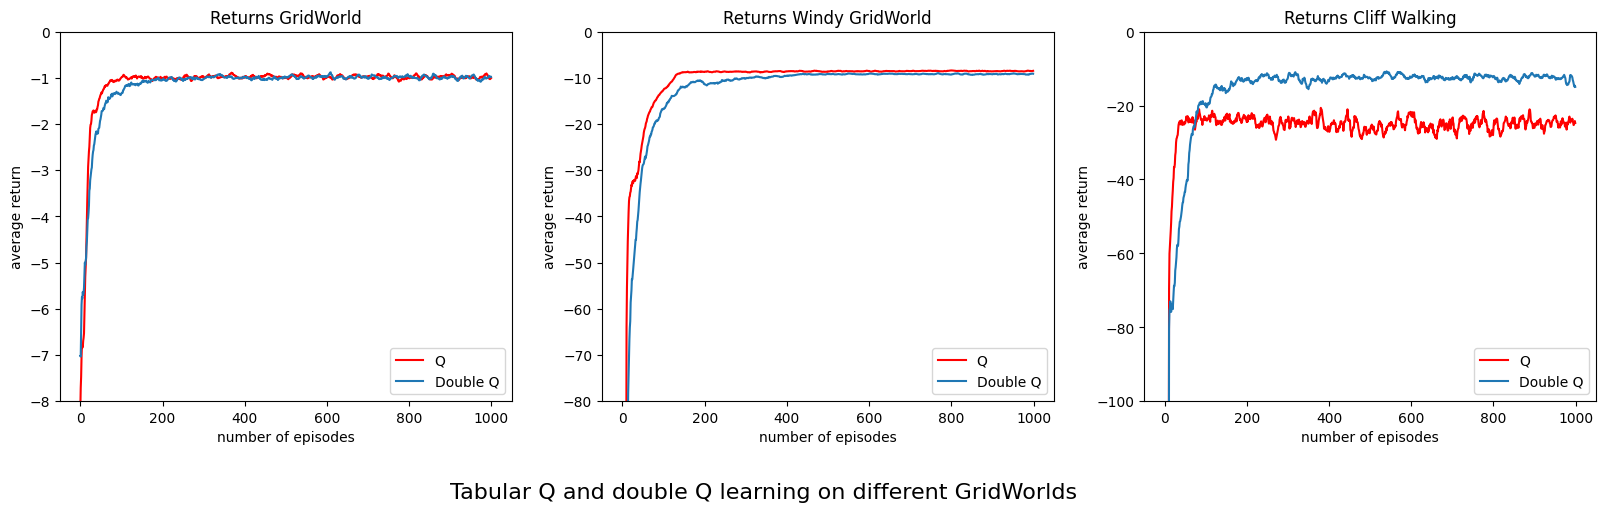

In [5]:
fig=plt.figure()
plt.subplot(1,3,1)
plt.subplots_adjust(left = -0.3, right = 2.1)
plt.plot(running_avg(np.mean(returns['q']['gw'], 0), 10), 'r', label = 'Q')
plt.plot(running_avg(np.mean(returns['qq']['gw'], 0), 10), label='Double Q')
plt.xlabel("number of episodes")
plt.ylabel("average return")
plt.legend()
# plt.text(400, -7, "t-value "+str(round(t_results_gw[0],2))+"    "+'p < 0.001')
plt.ylim(-8, 0)
plt.title('Returns GridWorld')

plt.subplot(1,3,2)
plt.plot(running_avg(np.mean(returns['q']['windy_gw'], 0), 10), 'r', label = 'Q')
plt.plot(running_avg(np.mean(returns['qq']['windy_gw'], 0), 10), label='Double Q')
plt.xlabel("number of episodes")
plt.ylabel("average return")
plt.legend()
plt.ylim(-80, 0)  
plt.title('Returns Windy GridWorld')

plt.subplot(1,3,3)
plt.plot(running_avg(np.mean(returns['q']['cw'], 0), 10), 'r',label='Q')
plt.plot(running_avg(np.mean(returns['qq']['cw'], 0), 10), label = 'Double Q')
plt.xlabel("number of episodes")
plt.ylabel("average return")
plt.legend()
plt.ylim(-100, 0)  
plt.title('Returns Cliff Walking')
fig.text(0.8, -0.1, 'Tabular Q and double Q learning on different GridWorlds', horizontalalignment='center', verticalalignment='bottom', fontsize=16)
plt.show()



In [6]:
QQ, (ep_len, ret) = double_q_learning(env_cw, 1000)
Q, (epq, retq) = q_learning(env_cw,1000)

100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 2871.38it/s]


In [7]:
from collections import Counter
env = env_cw
policy_qq = make_epsilon_greedy_policy(QQ, 0.1, env.action_space.n)
policy_q = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)


def show_most_common_path(policy):
    c = Counter()
    for i in range(500):
        path = []
        state = env.reset()
        R=0
        while True:
            path.append(state)        
            action_probs = policy(state)
            action = choose_action(cdf(action_probs))
            outcome = env.step(action)
            next_state = outcome[0]
            reward = outcome[1]
            R +=reward

            next_action = choose_action(cdf(policy(next_state)))
            next_best_action = np.argmax(policy(next_state)) 

            state = next_state
            action = next_action
            if outcome[2]==True:
                c[str(path)] += 1 
                break

    p = c.most_common(1)[0][0]
    p = eval(p)

    for n in p:
        print(np.unravel_index(n, env.shape))

show_most_common_path(policy_q)

(3, 0)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)


In [8]:
import random
def give_avg_randnorm(n):
    s = 0
    for i in range(n):
        s+= np.random.normal()+0.1
    if s>0:
        return 1
    else:
        return 0
s = 0
for j in range(10000):
    s+= give_avg_randnorm(10)
print(s/10000)




0.6146


In [9]:
def is_avg_negative(nr_evals, mu, sigma):
    avg = 0
    for i in range(nr_evals):
        avg+= sigma*np.random.normal()+mu
        if avg<0:
            return 1
    return 0
n = 10000
s = 0
for i in range(n):
    s+=is_avg_negative(5, 0.1, 1)
print(s/n)

0.6998
